In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import os
import joblib

# Define models and corresponding data files
models = {
    "RF": {"classifier": RandomForestClassifier(random_state=42),
           "files": [r"RF.xlsx"]},
    
    "XGB": {"classifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
            "files": [r"XGB.xlsx"]},

    "LGBM": {"classifier": lgb.LGBMClassifier(random_state=42),
            "files": [r"LGB.xlsx"]},

    "SVM": {"classifier": SVC(probability=True, random_state=42),
            "files": [r"SVM.xlsx"]},

    "KNN": {"classifier": KNeighborsClassifier(),
            "files": [r"KNN.xlsx"]},

    "ANN": {"classifier": MLPClassifier(max_iter=500, random_state=42),
            "files": [r"ANN.xlsx"]},

    "LR": {"classifier": LogisticRegression(max_iter=10000, random_state=42),
           "files": [r"LR.xlsx"]}
}

      age  sex        BMI  Hbp  cerebrovascular  CVD_inheritance  \
0      76    1  23.661439    1                1                0   
1      76    1  23.661439    1                0                0   
2      78    1  19.031142    1                1                0   
3      54    1  25.826446    1                0                0   
4      78    0  19.531250    1                0                0   
...   ...  ...        ...  ...              ...              ...   
1081   42    1  25.711662    0                0                0   
1082   40    1  30.421850    1                0                0   
1083   63    1  29.721079    0                0                0   
1084   41    1  24.221453    0                0                0   
1085   61    1  24.221453    0                0                0   

      smoking_index  LDL-C  NT_proBNP     cTnI   CK-MB       MYO  labels  
0               0.0   2.59    33411.0  1383.51   15.90   62.8000       1  
1               0.0   2.59    334

In [13]:
# Record results
roc_data_internal = {}
roc_data_external = {}

# Create a directory to save the models (current folder)
output_model_dir = "."
os.makedirs(output_model_dir, exist_ok=True)

# Train and plot ROC curves
for model_name, model_info in tqdm(models.items(), desc="Training Models"):
    # Load dataset
    df = pd.read_excel(model_info["files"][0])

    # Separate features and labels
    X = df.iloc[:, :-1]  # Take all columns except the last one
    y = df.iloc[:, -1]   # The last column is the label
    # Split into training, validation, and external test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_test_int, X_test_ext, y_test_int, y_test_ext = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Hyperparameter tuning using grid search
    param_grid = {
        "RF": {'n_estimators': [50, 100, 200, 300, 500], 'max_features': ['auto', 'sqrt', 'log2'], 
               'max_depth': [3, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 8], 'min_samples_leaf' : [1, 2, 4, 6],'bootstrap': [True, False]},
        "XGB": {'n_estimators': [50, 100, 200, 300, 500],'max_depth': [3, 5, 7, 10, 15, None], 'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'min_child_weight': [1, 5, 10], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 
                'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0.1, 1, 5]},
        "LGBM": {'n_estimators': [50, 100, 200, 300, 500], 'max_depth': [3, 5, 7, 10, 15, None], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 
                 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 
                 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0.1, 1, 5]},
        "SVM": {'C': [0.1, 1, 10, 100], 'Gamma': [1, 0.1, 0.01, 'scale'], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
        "KNN": {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],'p': [1, 2] },
        "ANN": {'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (100, 50)], 'activation': ['relu', 'tanh', 'logistic'], 'alpha': [0.0001, 0.001, 0.01],
               'solver': ['adam', 'sgd', 'lbfgs'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'max_iter': [100, 200, 500]},
        "LR": {'C': [0.1, 1, 10, 100], 'Penalty': ['l1', 'l2'], 'Solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [100, 200, 500]}
    }

    grid_search = GridSearchCV(model_info["classifier"], param_grid[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Calculate ROC curve and AUC for internal test set
    y_pred_int = best_model.predict_proba(X_test_int)[:, 1]
    fpr_int, tpr_int, _ = roc_curve(y_test_int, y_pred_int)
    auc_int = auc(fpr_int, tpr_int)
    roc_data_internal[model_name] = (fpr_int, tpr_int, auc_int)

    # Calculate ROC curve and AUC for external test set
    y_pred_ext = best_model.predict_proba(X_test_ext)[:, 1]
    fpr_ext, tpr_ext, _ = roc_curve(y_test_ext, y_pred_ext)
    auc_ext = auc(fpr_ext, tpr_ext)
    roc_data_external[model_name] = (fpr_ext, tpr_ext, auc_ext)

    # Record performance metrics (internal test set)
    metrics_internal[model_name] = {
        "Accuracy": accuracy_score(y_test_int, y_pred_int),
        "Precision": precision_score(y_test_int, y_pred_int),
        "Recall": recall_score(y_test_int, y_pred_int),
        "F1-Score": f1_score(y_test_int, y_pred_int)
    }

    # Record performance metrics (external test set)
    metrics_external[model_name] = {
        "Accuracy": accuracy_score(y_test_ext, y_pred_ext),
        "Precision": precision_score(y_test_ext, y_pred_ext),
        "Recall": recall_score(y_test_ext, y_pred_ext),
        "F1-Score": f1_score(y_test_ext, y_pred_ext)
    }

    # Predict probabilities
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate calibration curve, n_bins set to the number of test samples divided by 50
    n_bins = max(1, len(y_test) // 100)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=n_bins)
    
    # Save calibration curve data to DataFrame
    model_calibration_data = pd.DataFrame({
        "Model": [model_name] * len(prob_true),
        "Predicted_Probability": prob_pred,
        "True_Probability": prob_true
    })
    calibration_data = pd.concat([calibration_data, model_calibration_data], ignore_index=True)

    # Save the best model to the current directory
    model_output_path = os.path.join(output_model_dir, f"{model_name}_best_model.pkl")
    joblib.dump(best_model, model_output_path)

Training Models:  14%|█████████▌                                                         | 1/7 [00:10<01:00, 10.08s/it]D:\Anaconda\envs\test_1\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\envs\test_1\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\envs\test_1\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "D:\Anaconda\envs\test_1\lib\site-packages\xgboost\sklearn.py", line 1580

[LightGBM] [Info] Number of positive: 891, number of negative: 1561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 2452, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363377 -> initscore=-0.560737
[LightGBM] [Info] Start training from score -0.560737


Training Models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:24<00:00,  3.48s/it]


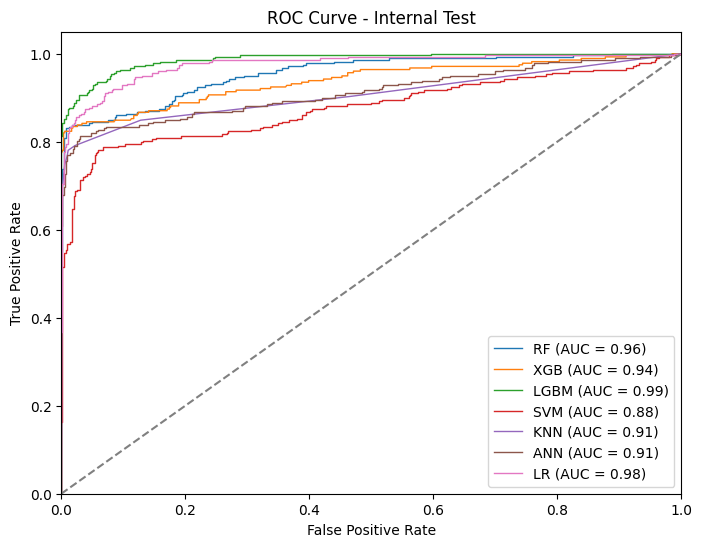

In [15]:
# Plot ROC curve for internal test set
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr, auc_score) in roc_data_internal.items():
    plt.plot(fpr, tpr, lw=1, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Internal Test')
plt.legend(loc="lower right")
plt.savefig('roc_internal.png')
plt.show()

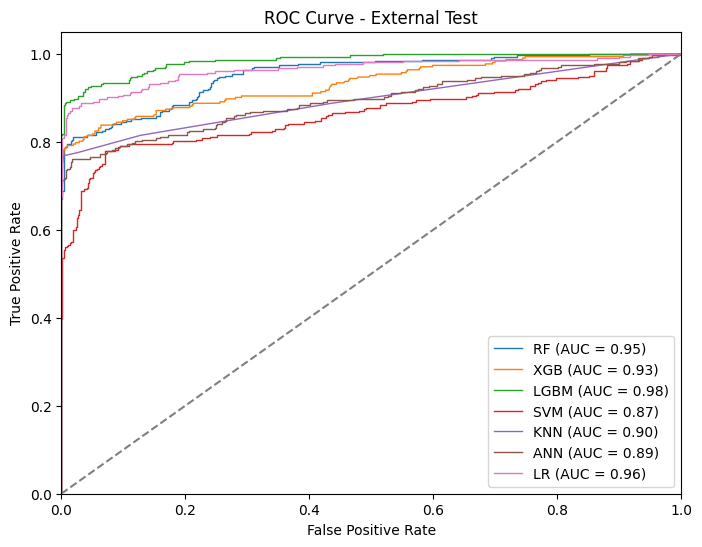

In [17]:
# Plot ROC curve for external test set
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr, auc_score) in roc_data_external.items():
    plt.plot(fpr, tpr, lw=1, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - External Test')
plt.legend(loc="lower right")
plt.savefig('roc_external.png')
plt.show()

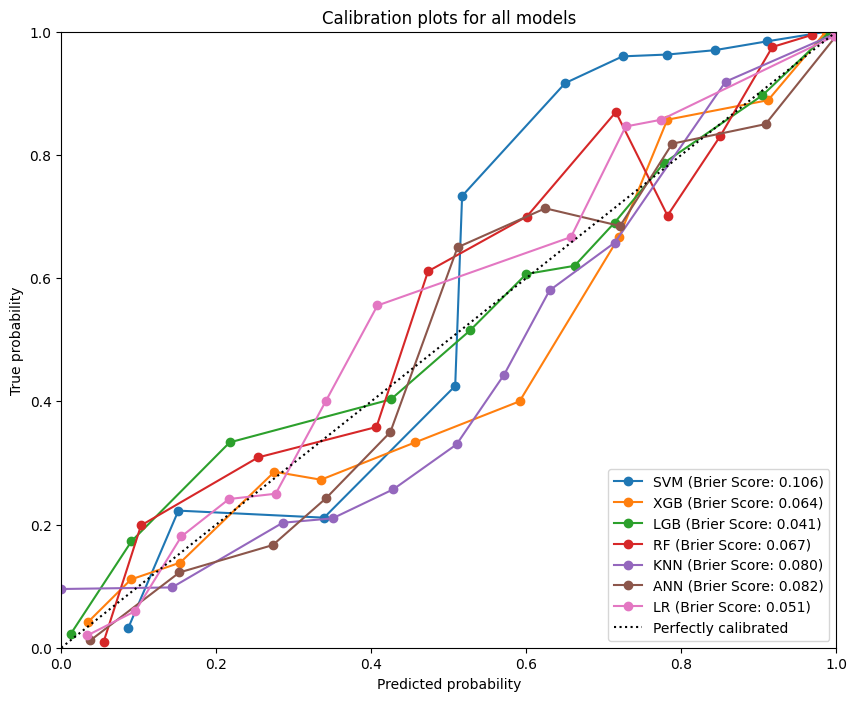

In [15]:
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr, auc_score) in roc_data_internal.items():
    plt.plot(prob_pred, prob_true, 'o-', label=f'{model_name} (Brier Score = {brier_score_loss(y_test, y_pred_proba):.3f})')

# Add legend and title
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plots for all models')
plt.legend(loc="lower left")
plt.savefig('calibration_plots_all_models.png')
plt.show()

# Export calibration curve data to CSV file
calibration_data.to_csv('calibration_data_all_models.csv', index=False)

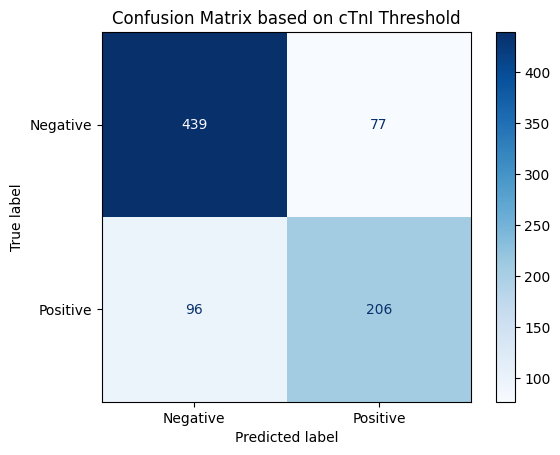

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import joblib
import shap
import numpy as np
import matplotlib
matplotlib.use('TkAgg')  # Solve the issue of SHAP image flashing on Windows

# ========================
# 1. Load data and split
# ========================
# Load data
df = pd.read_excel(r'LGB.xlsx')

# Split dataset
X = df.drop(columns=["labels"])
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test_int, X_test_ext, y_test_int, y_test_ext = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# ========================
# 2. Diagnosis based on cTnI threshold
# ========================
threshold_cTnI = 42.9
y_pred_cTnI = (X_test_ext['cTnI'] >= threshold_cTnI).astype(int)

cm_cTnI = confusion_matrix(y_test_ext, y_pred_cTnI)
disp_cTnI = ConfusionMatrixDisplay(confusion_matrix=cm_cTnI, display_labels=['Negative', 'Positive'])
disp_cTnI.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix based on cTnI Threshold')
plt.show()

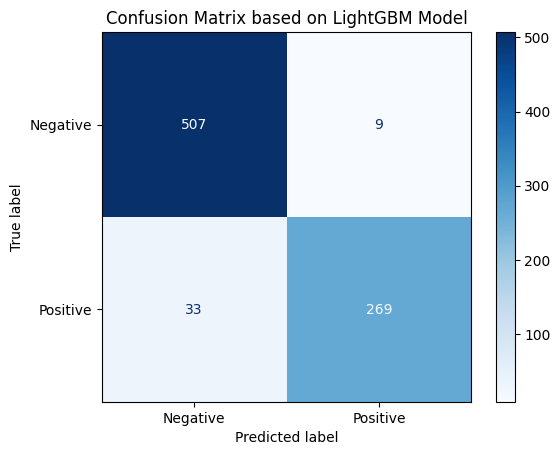

In [14]:
# ========================
# 3. Load saved LightGBM model and make predictions
# ========================
# Ensure the .pkl file is in the same directory as the current script, or modify the path to the correct location
best_lgb = joblib.load("LGBM_best_model.pkl")

# Predict the external test set
y_pred_ext_class = best_lgb.predict(X_test_ext)

# Display the confusion matrix
cm_lgb = confusion_matrix(y_test_ext, y_pred_ext_class)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=['Negative', 'Positive'])
disp_lgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix based on LightGBM Model')
plt.show()